In [7]:
import numpy as np
import pandas as pd
import json
import os
from pathlib import Path
import math

# --- Constants & Paths ---
DATA_DIR = Path(r"d:\fishinggame\precompute\data\1\1001")
MAP_DATA_DIR = Path(r"d:\fishinggame\precompute\Fishing_1006001_Dense_20260107_154037")

# Voxel Bitflags
FLAG_WATER = 1 << 0
FLAG_WATER_GRASS = 1 << 1
FLAG_STONE = 1 << 2
FLAG_DRIFTWOOD = 1 << 3
FLAG_PIER = 1 << 4
FLAG_DEEP_PIT = 1 << 5
FLAG_RIDGE = 1 << 6
FLAG_FAULT = 1 << 7
FLAG_ROCK_SHELF = 1 << 8
FLAG_BAY = 1 << 9
FLAG_MUD = 1 << 10
FLAG_GRAVEL = 1 << 11

# --- Load Map Metadata ---
map_meta_path = MAP_DATA_DIR / "map_data.json"
if map_meta_path.exists():
    with open(map_meta_path, "r", encoding="utf-8") as f:
        map_meta = json.load(f)
    print(f"Loaded Map Metadata: ID {map_meta.get('id') or map_meta.get('mapID')}")
else:
    print(f"ERROR: {map_meta_path} not found.")
    map_meta = {}

# --- Helper Logic ---
def get_global_layer_meta(meta):
    if "global" in meta:
        return meta["global"]
    return None

global_layer = get_global_layer_meta(map_meta)
if global_layer:
    print(f"Global Layer Meta: {json.dumps(global_layer, indent=2)}")

Loaded Map Metadata: ID 1006001
Global Layer Meta: {
  "name": "Global",
  "type": "Global",
  "format": "dense",
  "blockSize": 0,
  "dataFile": "Fishing_1006001_Global.npy",
  "indexFile": "",
  "blockCount": 0,
  "origin": [
    12.599998474121094,
    -6.811878204345703,
    -147.3000030517578
  ],
  "step": [
    1.5,
    1.0,
    1.5
  ],
  "dim": [
    134,
    8,
    134
  ]
}


In [8]:
class VoxelGrid:
    def __init__(self, layer_meta, data_dir):
        self.meta = layer_meta
        self.data_dir = data_dir
        
        self.origin = np.array(layer_meta['origin'])
        self.step = np.array(layer_meta['step'])
        self.dim = np.array(layer_meta['dim'])
        self.format = layer_meta.get('format', 'block_sparse')
        
        self.data_file = data_dir / layer_meta['dataFile']
        
        if self.format == 'dense':
            print(f"Loading Dense Data: {self.data_file}...")
            self.dense_grid = np.load(self.data_file)
            print(f"Dense Grid Shape: {self.dense_grid.shape}")
            if tuple(self.dense_grid.shape) != tuple(self.dim):
                print(f"WARNING: Shape mismatch! Meta: {self.dim}, Loaded: {self.dense_grid.shape}")
                
        elif self.format == 'block_sparse':
            self.block_size = layer_meta['blockSize']
            self.index_file = data_dir / layer_meta['indexFile']
            
            # Load Data
            print(f"Loading Index: {self.index_file}...")
            self.indices = np.load(self.index_file) # (N, 3)
            print(f"Loading Data: {self.data_file}...")
            self.data_blocks = np.load(self.data_file) # (N, 16, 16, 16)
            
            # Build Index Map
            self.block_map = {}
            for i, idx in enumerate(self.indices):
                self.block_map[tuple(idx)] = i
            print(f"VoxelGrid Loaded (BlockSparse). {len(self.indices)} active blocks.")
        else:
            raise ValueError(f"Unknown format: {self.format}")

    def get_voxel(self, wx, wy, wz):
        """Get voxel value from World Coordinates."""
        # 1. World -> Grid
        gx = int((wx - self.origin[0]) / self.step[0])
        gy = int((wy - self.origin[1]) / self.step[1])
        gz = int((wz - self.origin[2]) / self.step[2])
        
        # Boundary Check
        if not (0 <= gx < self.dim[0] and 0 <= gy < self.dim[1] and 0 <= gz < self.dim[2]):
            return 0
            
        if self.format == 'dense':
             return self.dense_grid[gx, gy, gz]
        
        # Block Sparse Lookup
        bx = gx // self.block_size
        by = gy // self.block_size
        bz = gz // self.block_size
        
        lx = gx % self.block_size
        ly = gy % self.block_size
        lz = gz % self.block_size
        
        block_idx = self.block_map.get((bx, by, bz))
        if block_idx is None:
            return 0
            
        return self.data_blocks[block_idx, lx, ly, lz]

# Initialize Global Grid
if global_layer:
    global_grid = VoxelGrid(global_layer, MAP_DATA_DIR)
else:
    print("Global Grid initialization skipped.")

Loading Dense Data: d:\fishinggame\precompute\Fishing_1006001_Dense_20260107_154037\Fishing_1006001_Global.npy...
Dense Grid Shape: (134, 8, 134)


In [9]:
# Test Voxel Retrieval (Center of map?)
center_x = global_grid.origin[0] + (global_grid.dim[0] * global_grid.step[0]) / 2
center_z = global_grid.origin[2] + (global_grid.dim[2] * global_grid.step[2]) / 2
center_y = global_grid.origin[1] + (global_grid.dim[1] * global_grid.step[1]) / 2

print(f"Sampling center: {center_x, center_y, center_z}")
val = global_grid.get_voxel(center_x, center_y, center_z)
print(f"Voxel Value: {val}, Bin: {bin(val)}")

Sampling center: (113.0999984741211, -2.811878204345703, -46.80000305175781)
Voxel Value: 0, Bin: 0b0


In [10]:
# Load Affinity JSONs
def load_json(filename):
    path = DATA_DIR / filename
    if not path.exists():
        print(f"WARNING: {filename} not found at {path}")
        return {}
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

print("Loading Configuration Files...")
fish_env_affinity = load_json("fish_env_affinity.json")
struct_affinity = load_json("struct_affinity.json")
temp_affinity = load_json("temp_affinity.json")
layer_affinity = load_json("water_layer_affinity.json")
env_affinity_const = load_json("env_affinity_const.json")
fish_stock = load_json("fish_stock.json")
fish_pond_list = load_json("fish_pond_list.json")
fish_release = load_json("fish_release.json")

print("Configs Loaded.")
print(f"Struct Affinity Keys: {list(struct_affinity.keys())[:5]}")

Loading Configuration Files...
Configs Loaded.
Struct Affinity Keys: ['2010001', '2010002', '2010003', '2010004', '2010005']


In [11]:
# --- Struct Mapping ---
# Map Bitflags to Struct IDs (See data_formula.md)
# ID | Name | BitFlag
STRUCT_MAP = [
    (FLAG_WATER_GRASS, 1), # Grass
    (FLAG_STONE, 2),       # Rock
    (FLAG_DRIFTWOOD, 3),   # Wood
    (FLAG_PIER, 4),        # Bridge
    (FLAG_DEEP_PIT, 5),    # Hole
    (FLAG_RIDGE, 6),       # Ridge
    (FLAG_FAULT, 7),       # Break
    (FLAG_ROCK_SHELF, 8),  # Ledge
    (FLAG_BAY, 9),         # Bay
    (FLAG_MUD, 10),        # Mud
    (FLAG_GRAVEL, 11),     # Gravel
]

# Special Case: OpenWater (ID 0) = FLAG_WATER & ~ALL_OTHER_FLAGS

def compute_struct_slots(voxel_grid):
    """
    Convert voxel bitmask grid to struct_slots tensor (X, Y, Z, 3).
    Each slot holds a Struct ID or -1 if empty.
    """
    print("Computing Struct Slots...")
    shape = voxel_grid.shape
    slots = np.full(shape + (3,), -1, dtype=np.int16) # (X,Y,Z, 3)
    
    # We can vectorize this to some extent, but a loop over types might be easier for reading.
    # Approach:
    # 1. Create a running "count" grid.
    # 2. Iterate through STRUCT_MAP.
    # 3. If bit is set, place ID in the next available slot.
    
    counts = np.zeros(shape, dtype=np.int8)
    
    for flag, struct_id in STRUCT_MAP:
        # Find where this flag is set
        mask = (voxel_grid & flag) > 0
        
        # We need to fill the slot at `counts`
        # This is tricky to vectorize efficiently for "variable slot index" in pure numpy without python loop over pixels
        # But since max slots is small (3), we can just mask based on counts.
        
        # Slot 0
        mask0 = mask & (counts == 0)
        slots[mask0, 0] = struct_id
        counts[mask0] += 1
        
        # Slot 1 (for pixels that already had 1 struct)
        mask1 = mask & (counts == 1)
        slots[mask1, 1] = struct_id
        counts[mask1] += 1
        
        # Slot 2
        mask2 = mask & (counts == 2)
        slots[mask2, 2] = struct_id
        counts[mask2] += 1
        
    # OpenWater Logic:
    # If FLAG_WATER is set AND counts == 0, then it's OpenWater (ID 0)
    water_mask = (voxel_grid & FLAG_WATER) > 0
    open_water_mask = water_mask & (counts == 0)
    slots[open_water_mask, 0] = 0 # ID 0
    
    print("Struct Slots computed.")
    return slots

if 'global_grid' in locals() and global_grid.format == 'dense':
    struct_slots = compute_struct_slots(global_grid.dense_grid)
    print("Struct Slots Shape:", struct_slots.shape)
    
    # Verify some non-empty slots
    non_neg = struct_slots[struct_slots != -1]
    print(f"Sample Non-Empty Structs: {non_neg[:20]}")
    print(f"Unique Structs Found: {np.unique(non_neg)}")

Computing Struct Slots...
Struct Slots computed.
Struct Slots Shape: (134, 8, 134, 3)
Sample Non-Empty Structs: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Unique Structs Found: [ 0  1  2  3  4 10 11]


In [12]:
# Load Map Basic & Pond List
map_basic = load_json("map_basic.json")
fish_pond_list = load_json("fish_pond_list.json")
env_const = load_json("env_affinity_const.json")

# Extract info for current Map ID
current_map_id = map_meta.get('id') or map_meta.get('mapID')
print(f"Current Map ID: {current_map_id}")

# Find MapBasic Info
current_map_basic = map_basic.get(str(current_map_id))
if current_map_basic:
    print(f"MapBasic Found: {current_map_basic}")
    water_level = current_map_basic.get('water_level', 0.0) # Assume 0 if not found
    water_max_depth = current_map_basic.get('water_max_z', 20.0) # Default?
    print(f"Water Level: {water_level}, Max Depth: {water_max_depth}")
else:
    print("WARNING: MapBasic entry not found!")
    water_level = 0.0
    water_max_depth = 20.0

# Extract Env Constants
top_layer_height = env_const.get('1', {}).get('WATER_TOP_LAYER_HEIGHT', 2.0)
top_layer_ratio = env_const.get('1', {}).get('WATER_TOP_LAYER_RATIO', 0.2)
bottom_layer_height = env_const.get('1', {}).get('WATER_BOTTOM_LAYER_HEIGHT', 2.0)
bottom_layer_ratio = env_const.get('1', {}).get('WATER_BOTTOM_LAYER_RATIO', 0.2)

print(f"Layer Configs: TopH={top_layer_height}, TopR={top_layer_ratio}, BotH={bottom_layer_height}, BotR={bottom_layer_ratio}")

Current Map ID: 1006001
Layer Configs: TopH=2.0, TopR=0.2, BotH=2.0, BotR=0.2


In [13]:
print(f"MapBasic Keys Sample: {list(map_basic.keys())[:5]}")
print(f"PondList Keys Sample: {list(fish_pond_list.keys())[:5]}")

# Maybe 1006001 is a SceneID, and we need map_scene.json?
map_scene = load_json("map_scene.json")
print(f"MapScene Keys Sample: {list(map_scene.keys())[:5]}")

scene_info = map_scene.get(str(current_map_id))
print(f"Scene Info for {current_map_id}: {scene_info}")

MapBasic Keys Sample: ['101', '102', '103', '104', '105']
PondList Keys Sample: ['301020000', '301020001', '301020002', '301020003', '301020004']
MapScene Keys Sample: ['1001', '1002', '1003', '1004', '1005']
Scene Info for 1006001: None


In [14]:
# Search for ID in configs
found_map_id = False
for k in map_basic:
    if str(k) == str(current_map_id):
        print(f"Found in MapBasic! {map_basic[k]}")
        found_map_id = True
        
if not found_map_id:
    # Try to deduce from Voxel Grid
    print("Deducing Water Limits from Voxel Grid...")
    if global_grid.format == 'dense':
        # Assuming Y is vertical index 1
        # Find all voxels with FLAG_WATER
        # dense_grid is (X, Y, Z)
        
        # We need to find Y indices where Water is present
        # axis 1 is Y
        y_indices = np.where(np.any(global_grid.dense_grid & FLAG_WATER, axis=(0, 2)))[0]
        
        if len(y_indices) > 0:
            min_gy = y_indices.min()
            max_gy = y_indices.max()
            
            min_y_world = global_grid.origin[1] + min_gy * global_grid.step[1]
            max_y_world = global_grid.origin[1] + (max_gy + 1) * global_grid.step[1] # Top of the voxel
            
            print(f"Voxel Y Range: Grid[{min_gy}, {max_gy}] -> World[{min_y_world:.2f}, {max_y_world:.2f}]")
            
            # Assume Max Water Level is 'max_y_world' or 0.0?
            # Typically water surface is at fixed height.
            # If map origin Y is -6.8 and max Y is 1.2, then 0.0 is inside.
            
            computed_water_level = max_y_world
            computed_max_depth = computed_water_level - min_y_world
            
            print(f"Computed Water Level: {computed_water_level}")
            print(f"Computed Max Depth: {computed_max_depth}")
            
            water_level = computed_water_level
            water_max_depth = computed_max_depth
        else:
            print("No water voxels found!")
    else:
        # iterate indices for block sparse
        pass

Deducing Water Limits from Voxel Grid...
Voxel Y Range: Grid[3, 6] -> World[-3.81, 0.19]
Computed Water Level: 0.18812179565429688
Computed Max Depth: 4.0


In [15]:
# --- Precompute Spatial Fields ---

def precompute_spatial_fields(grid, water_level, max_depth, env_const):
    print("Precomputing Spatial Fields...")
    dense = grid.dense_grid
    nx, ny, nz = dense.shape
    
    # 1. Bathymetry (Bottom Y Index)
    # Initialize with full height (ny) to indicate no bottom found yet
    bottom_idx_map = np.full((nx, nz), ny, dtype=np.int32)
    
    # Iterate Y from bottom (0) to top (ny)
    # We want the LOWEST water voxel.
    for y in range(ny):
        # mask of water at this layer
        is_water = (dense[:, y, :] & FLAG_WATER) > 0
        # where bottom not set yet AND is water -> set bottom
        update_mask = is_water & (bottom_idx_map == ny)
        bottom_idx_map[update_mask] = y
        
    # 2. Layer ID Tensor & Temperature Tensor
    layer_ids = np.zeros((nx, ny, nz), dtype=np.int8) # 0:None, 1:Surface, 2:Middle, 3:Bottom
    temperature_field = np.zeros((nx, ny, nz), dtype=np.float32)
    
    # Constants for Temp
    surface_t = 25.0 # Default
    hypolimnion_t = 15.0 # Default
    temp_gradient = (surface_t - hypolimnion_t) / max_depth if max_depth > 0.1 else 0
    
    # Constants for Layer
    top_h = env_const.get('1', {}).get('WATER_TOP_LAYER_HEIGHT', 2.0)
    top_r = env_const.get('1', {}).get('WATER_TOP_LAYER_RATIO', 0.2)
    bot_h = env_const.get('1', {}).get('WATER_BOTTOM_LAYER_HEIGHT', 2.0)
    bot_r = env_const.get('1', {}).get('WATER_BOTTOM_LAYER_RATIO', 0.2)

    for y in range(ny):
        # Only process water voxels
        voxel_mask = (dense[:, y, :] & FLAG_WATER) > 0
        if not np.any(voxel_mask):
            continue
            
        # World Y (Center of voxel)
        world_y = grid.origin[1] + (y + 0.5) * grid.step[1]
        
        # Depth from surface
        depth = water_level - world_y
        
        # Distance from Bottom
        # We need per-column bottom world_y
        bottom_indices = bottom_idx_map[voxel_mask]
        bottom_world_y = grid.origin[1] + (bottom_indices + 0.5) * grid.step[1]
        dist_to_bottom = world_y - bottom_world_y
        
        # Rel Depth
        rel_depth = depth / max_depth if max_depth > 0 else 0
        
        # --- Layer Logic ---
        # 1. Surface
        # depth - top_h <= 0 OR rel_depth - top_r <= 0 ?? 
        # data_formula mentions: "饵的深度 - 表层最小厚度 <= 0" -> Surface
        # AND "饵的相对深度 - 表层深度比例 <= 0" -> Surface
        # Usually it's OR? Or checked sequentially?
        # Formula says "If A... else if B... else..."
        
        # Vectorized assignments is tricky with varying logic branches.
        # But we can compute masks.
        
        n_pts = np.sum(voxel_mask)
        current_layer = np.zeros(n_pts, dtype=np.int8)
        
        # Cond 1: Surface
        is_surface = (depth <= top_h) | (rel_depth <= top_r)
        
        # Cond 2: Middle / Bottom (Else)
        # Check logic: "饵距水底距离 - 底层最小厚度 > 0" -> Middle
        # "Relative dist > bot_r" -> Middle
        
        # Dist to bottom check
        is_middle_abs = (dist_to_bottom > bot_h)
        # Relative logic for bottom: "饵距水底距离 / MaxDepth - BotR"
        is_middle_rel = ((dist_to_bottom / max_depth) > bot_r) if max_depth > 0 else np.zeros(n_pts, dtype=bool)
        
        is_middle = (~is_surface) & (is_middle_abs | is_middle_rel)
        is_bottom = (~is_surface) & (~is_middle)
        
        current_layer[is_surface] = 1
        current_layer[is_middle] = 2
        current_layer[is_bottom] = 3
        
        # Fill tensor using fancy indexing
        # dense[:, y, :] is (nx, nz). we need flat indexing for mask
        # We can simulate by:
        full_layer_slice = layer_ids[:, y, :]
        full_layer_slice[voxel_mask] = current_layer
        layer_ids[:, y, :] = full_layer_slice
        
        # --- Temp Logic ---
        # T = T_surf - grad * depth
        t_vals = surface_t - temp_gradient * depth
        
        full_temp_slice = temperature_field[:, y, :]
        full_temp_slice[voxel_mask] = t_vals
        temperature_field[:, y, :] = full_temp_slice

    print("Spatial Fields Computed.")
    return layer_ids, temperature_field

if 'global_grid' in locals() and global_grid.format == 'dense':
    layer_field, temp_field = precompute_spatial_fields(global_grid, water_level, water_max_depth, env_const)
    
    print(f"Layer Distribution: {np.unique(layer_field, return_counts=True)}")
    print(f"Temp Range: {temp_field.min()} - {temp_field.max()}")

Precomputing Spatial Fields...
Spatial Fields Computed.
Layer Distribution: (array([0, 1, 2, 3], dtype=int8), array([138515,   4409,    161,    563], dtype=int64))
Temp Range: 0.0 - 23.75


In [16]:
# Pick a Test Fish
print("Fish Release Keys sample:", list(fish_release.keys())[:5])
# Let's try to find a valid one
test_fish_key = list(fish_release.keys())[0] 
print(f"Selected Test Fish Key: {test_fish_key}")
fish_release_info = fish_release[test_fish_key]
print("Release Info:", fish_release_info)

# Get Fish Species ID from Release Info? 
# Usually fish_release maps release_id -> {species_id, ...}
# Let's inspect structure
pass

Fish Release Keys sample: ['300010', '300020', '300030', '300040', '300050']
Selected Test Fish Key: 300010
Release Info: {'id': 300010, 'name': 'Release_Alewife_Young_dew', 'fishNum': 87646, 'probWeightIdeal': 87646, 'minEnvCoeff': 0, 'minAdaptCoeff': 0, 'lengthMin': 19, 'lengthMax': 24, 'weightMin': 60, 'weightMax': 120, 'isReduce': False}


In [17]:
# Inspect Affinity Keys
print("Temp Affinity Keys Sample:", list(temp_affinity.keys())[:5])
print("Struct Affinity Keys Sample:", list(struct_affinity.keys())[:5])
print("Layer Affinity Keys Sample:", list(layer_affinity.keys())[:5])

# Check if Release ID 300010 is in there
print(f"Is 300010 in TempAffinity? {'300010' in temp_affinity}")
print(f"Is 300010 in StructAffinity? {'300010' in struct_affinity}")

# If not, we need a mapping.
# maybe fish_release name contains hint? 'Release_Alewife_Young_dew'
# maybe fish_species.json? (we have basic_fish_species.json in file list)
# I didn't load basic_fish_species.json.

if '300010' not in temp_affinity:
    print("ReleaseID mismatch. Need to find SpeciesID.")
    # Load basic_fish_species
    fish_species = load_json("basic_fish_species.json")
    print("Species Keys:", list(fish_species.keys())[:5])
    # Can we find 'Alewife' in species?
    pass

Temp Affinity Keys Sample: ['2020001', '2020002', '2020003', '2020004', '2020005']
Struct Affinity Keys Sample: ['2010001', '2010002', '2010003', '2010004', '2010005']
Layer Affinity Keys Sample: ['2030001', '2030002', '2030003', '2030004', '2030005']
Is 300010 in TempAffinity? False
Is 300010 in StructAffinity? False
ReleaseID mismatch. Need to find SpeciesID.
Species Keys: ['101020001', '101020002', '101020003', '101020004', '101020005']


In [18]:
# Inspect fish_env_affinity
print("FishEnvAffinity Keys Sample:", list(fish_env_affinity.keys())[:5])
sample_key = list(fish_env_affinity.keys())[0]
print(f"Sample Entry [{sample_key}]: {fish_env_affinity[sample_key]}")

# Check if 300010 is a key
is_release_key = '300010' in fish_env_affinity
print(f"Is 300010 in FishEnvAffinity? {is_release_key}")

if is_release_key:
    test_env_affinity = fish_env_affinity['300010']
    print("Found Link:", test_env_affinity)
    # Extract IDs
    # Likely fields like 'tempAffinityGroup', 'structAffinityGroup' etc.

FishEnvAffinity Keys Sample: ['1010001', '1010002', '1010003', '1010004', '1010005']
Sample Entry [1010001]: {'id': 1010001, 'name': 'Fish_Largemouth_Bass_Young', 'structId': 2010080, 'tempId': 2020070, 'layerId': 2030080, 'lightId': 2040001, 'baitCoeffGroup': 80000, 'baitTypeCoeffGroup': 3007, 'periodCoeffGroup': 2010, 'pressureSensitivity': 1.1, 'minAdaptLureRatio': 0.05, 'maxAdaptLureRatio': 0.4, 'underLengthDecayCoeff': 5, 'overLengthDecayCoeff': 3, 'maxAcceptLengthRatio': 0.8, 'mark': '暖水植被区表中层掠食鱼(Centrarchidae)'}
Is 300010 in FishEnvAffinity? False


In [19]:
# Load Stock Release
stock_release = load_json("stock_release.json")
print("Stock Release Keys Sample:", list(stock_release.keys())[:5])

# Check 300010
if '300010' in stock_release:
    print(f"Found 300010 in StockRelease: {stock_release['300010']}")
else:
    print("300010 not in StockRelease.")

# Check if fish_release has other fields I missed?
# I printed the whole dict earlier and it didn't show speciesId. 
# {'id': 300010, 'name': 'Release_Alewife_Young_dew', 'fishNum': 87646, 'probWeightIdeal': 87646, 'minEnvCoeff': 0, 'minAdaptCoeff': 0, 'lengthMin': 19, 'lengthMax': 24, 'weightMin': 60, 'weightMax': 120, 'isReduce': False}
# Name 'Release_Alewife_Young_dew' might be the key.

# Let's check basics_fish_species names.
fish_species = load_json("basic_fish_species.json")
# Create name -> id map
species_name_map = {}
for k, v in fish_species.items():
    if 'name' in v:
        species_name_map[v['name']] = k
        
print(f"Species Name Map Sample: {list(species_name_map.items())[:3]}")

# Try to match 'Release_Alewife_Young_dew' to Species Name
# Remove 'Release_' and '_dew'? -> 'Alewife_Young'?
# Or maybe 'Fish_Alewife_Young'?
pass

Stock Release Keys Sample: ['4000010', '4000020', '4000030', '4000040', '4000050']
300010 not in StockRelease.
Species Name Map Sample: [('fish_redear_sunfish', '101020001'), ('fish_buffalo', '101020002'), ('fish_bowfin', '101020003')]


In [20]:
# Search for 'Alewife'
target_species_id = None
for name, sid in species_name_map.items():
    if 'alewife' in name.lower():
        print(f"Found Match: {name} -> {sid}")
        target_species_id = sid
        break
        
if target_species_id:
    # Check Affinity
    if target_species_id in fish_env_affinity:
        print(f"Affinity Info Found for {target_species_id}: {fish_env_affinity[target_species_id]}")
        species_affinity_info = fish_env_affinity[target_species_id]
        
        # Extract Component IDs
        struct_group_id = str(species_affinity_info.get('structId'))
        temp_group_id = str(species_affinity_info.get('tempId'))
        layer_group_id = str(species_affinity_info.get('layerId'))
        
        print(f"IDs: Struct={struct_group_id}, Temp={temp_group_id}, Layer={layer_group_id}")
        
        # Verify component configs exist
        print(f"Struct Config Exists: {struct_group_id in struct_affinity}")
        print(f"Temp Config Exists: {temp_group_id in temp_affinity}")
        print(f"Layer Config Exists: {layer_group_id in layer_affinity}")
        
    else:
        print(f"Affinity Info NOT found for {target_species_id} in fish_env_affinity keys.")
else:
    print("Alewife not found in species.")

Found Match: fish_alewife -> 101020007
Affinity Info NOT found for 101020007 in fish_env_affinity keys.


In [21]:
# Switch to Known ID 1010001
fish_id = '1010001'
affinity_info = fish_env_affinity[fish_id]
print(f"Using Fish ID {fish_id}: {affinity_info.get('name')}")

struct_group_id = str(affinity_info.get('structId'))
temp_group_id = str(affinity_info.get('tempId'))
layer_group_id = str(affinity_info.get('layerId'))

print(f"Affinity Groups: Struct={struct_group_id}, Temp={temp_group_id}, Layer={layer_group_id}")

# --- Calculation Logic ---

def compute_affinity_field(struct_slots, layer_field, temp_field, 
                           struct_config, layer_config, temp_config,
                           env_const):
    print("Computing Affinity Field...")
    
    # 1. Struct Affinity
    # struct_config is dict {struct_id: coeff}
    # We need a lookup array max_struct_id -> coeff
    # struct_slots has IDs up to 11. 
    max_sid = 12
    struct_lookup = np.zeros(max_sid, dtype=np.float32)
    # Fill lookup
    # struct_affinity.json structure: "2010001": {"id":..., "coeff": 0.5, "structType": 1}
    # We need to map structType -> coeff.
    # But struct_affinity keys are GroupIDs (2010080).
    # The config passed in is specific to the Group?
    # Wait, struct_affinity.json is a LIST of entries or Dict of ID -> Entry?
    # It is Dict: "2010001": {...}.
    # BUT `fish_env_affinity` gave `structId`: 2010080.
    # struct_affinity.json has entries for DIFFERENT structTypes under DIFFERENT keys?
    # OR does `structId` 2010080 refer to a GROUP of entries?
    
    # Let's inspect struct_affinity content for key 2010080 (if it exists)
    # OR maybe 2010080 is a single entry?
    # Usually "Structure Preference" implies preferences for ALL structures.
    # If 2010080 is just ONE entry, how do we get prefs for other structs?
    # Maybe 2010080 points to a Group in another table?
    pass

# We need to debug the Structure Config structure before writing the function.
# Let's peek at struct_affinity[struct_group_id] if it exists.
print(f"Struct Config Entry for {struct_group_id}: {struct_affinity.get(struct_group_id)}")

Using Fish ID 1010001: Fish_Largemouth_Bass_Young
Affinity Groups: Struct=2010080, Temp=2020070, Layer=2030080
Struct Config Entry for 2010080: {'id': 2010080, 'name': 'Cover_Largemouth_Bass', 'List': [{'structType': 0, 'coeff': 0}, {'structType': 1, 'coeff': 0}, {'structType': 2, 'coeff': 0}, {'structType': 3, 'coeff': 0}, {'structType': 4, 'coeff': 0}, {'structType': 5, 'coeff': 0}, {'structType': 6, 'coeff': 1}, {'structType': 7, 'coeff': 0}, {'structType': 8, 'coeff': 0}, {'structType': 9, 'coeff': 0}, {'structType': 10, 'coeff': 0}, {'structType': 11, 'coeff': 0}], 'mark': ''}


In [22]:
# Inspect Temp & Layer Configs
print(f"Temp Config for {temp_group_id}: {temp_affinity.get(temp_group_id)}")
print(f"Layer Config for {layer_group_id}: {layer_affinity.get(layer_group_id)}")

Temp Config for 2020070: {'id': 2020070, 'name': 'Temp_Largemouth_Bass', 'temperatureFav': 210, 'tempAffectedRatio': 12, 'tempThreshold': 0.4, 'mark': ''}
Layer Config for 2030080: {'id': 2030080, 'name': 'FeedLayer_Largemouth_Bass', 'List': [{'layerType': 1, 'coeff': 1}, {'layerType': 2, 'coeff': 1}, {'layerType': 3, 'coeff': 1}], 'mark': ''}


In [23]:
def compute_affinity_field(struct_slots, layer_field, temp_field, 
                           struct_group_id, layer_group_id, temp_group_id,
                           struct_affinity_db, layer_affinity_db, temp_affinity_db,
                           env_const):
    print(f"Computing Affinity for Groups: S={struct_group_id}, L={layer_group_id}, T={temp_group_id}")
    
    # 1. Prepare Struct Lookup
    max_sid = 15
    struct_lookup = np.zeros(max_sid, dtype=np.float32)
    s_conf = struct_affinity_db.get(struct_group_id, {})
    if 'List' in s_conf:
        for item in s_conf['List']:
            st = item.get('structType')
            co = item.get('coeff', 0.0)
            if st < max_sid:
                struct_lookup[st] = co
    else:
        print("WARNING: Struct Config missing 'List'. Using zeros.")
        
    # 2. Prepare Layer Lookup
    # Layer ID: 1=Surface, 2=Middle, 3=Bottom
    layer_lookup = np.zeros(4, dtype=np.float32) 
    l_conf = layer_affinity_db.get(layer_group_id, {})
    if 'List' in l_conf:
        for item in l_conf['List']:
            lt = item.get('layerType') # 1, 2, 3
            co = item.get('coeff', 0.0)
            if lt < 4:
                layer_lookup[lt] = co
    else:
        # Maybe flat fields?
        # Let's handle flat fields if 'List' is missing but fields like 'surfaceCoeff' exist?
        # Based on previous step, we'll see output. Assuming List for consistency with Struct.
        pass

    # 3. Prepare Temp Params
    t_conf = temp_affinity_db.get(temp_group_id, {})
    # Expect: temperature_fav, temp_affected_ratio, temp_threshold
    t_fav = t_conf.get('temperatureFav', 25.0)
    t_ratio = t_conf.get('tempAffectedRatio', 1.0)
    t_thresh = t_conf.get('tempThreshold', 0.001)
    
    # Global Tolerance
    t_global_width = env_const.get('1', {}).get('TEMP_TOLERANCE_WIDTH', 10.0)
    
    print(f"Temp Params: Fav={t_fav}, Ratio={t_ratio}, Thresh={t_thresh}, GlobalWidth={t_global_width}")
    
    # --- Execute Calculations ---
    
    # A. Struct Affinity
    # struct_slots is (X,Y,Z, 3). Look up each slot.
    # We want max over the last axis.
    # struct_vals (X,Y,Z, 3)
    struct_vals = struct_lookup[struct_slots] 
    # Handle -1? struct_lookup[-1] -> struct_lookup index is wrap around or error?
    # -1 in numpy behaves as "last element". 
    # We should ensure struct_lookup is large enough or handle -1.
    # My struct_lookup is size 15. -1 refers to index 14. 
    # I should set index 14 to 0.0 explicitly? Or just ensure -1 maps to 0.
    
    # Better: Mask limits.
    # Actually, struct_slots was initialized to -1.
    # Let's map -1 to 0 (OpenWater) or 12 (None)? 
    # ID 0 is OpenWater. -1 is "No Struct".
    # "No Struct" coeff should be 0? Or ignored in MAX?
    # If a voxel has ID 2 and -1, -1, max is coeff(2).
    # so coeff(-1) should be 0.
    
    # Let's fix -1 indices to a safe "Zero Coeff" index.
    safe_slots = struct_slots.copy()
    safe_slots[safe_slots == -1] = 14 # Use 14 as empty
    struct_lookup[14] = 0.0
    
    struct_vals = struct_lookup[safe_slots]
    aff_struct = np.max(struct_vals, axis=3)
    
    # B. Layer Affinity
    aff_layer = layer_lookup[layer_field] # (X,Y,Z)
    
    # C. Temp Affinity
    # Formula: exp( - (T - Tfav)^2 / (Width * ratio^2) )
    # Note: data_formula says: (Width * ratio^2) in denominator?
    # "全局温差忍耐系数 × 此鱼种温差忍耐系数^2"
    # Wait, "全局" usually is separate?
    # Formula: `e^(-(det_T)^2 / (GlobalWidth * ratio^2))` 
    denom = t_global_width * (t_ratio ** 2)
    if denom < 1e-6: denom = 1e-6
    
    delta_t = temp_field - t_fav
    exponent = - (delta_t ** 2) / denom
    aff_temp = np.exp(exponent)
    
    # Threshold
    aff_temp[aff_temp < t_thresh] = 0.0
    
    # --- Combine ---
    # EnvCoeff = AffStruct * AffLayer * AffTemp
    # (Assuming multiplicated? data_formula says: max(product, min_threshold))
    # "max( 水温亲和系数 × 结构亲和系数 × 觅食水层亲和系数 ... , 最小环境系数阈值 )"
    
    env_coeff_raw = aff_struct * aff_layer * aff_temp
    
    # Min Threshold logic (applied later or here?)
    # "min_env_threshold" is from FishRelease.
    # We return the raw env coeff part.
    
    print("Affinity Field Computed.")
    return env_coeff_raw, aff_struct, aff_layer, aff_temp

# Run Calculation
if 'global_grid' in locals() and global_grid.format == 'dense':
    env_raw, a_struct, a_layer, a_temp = compute_affinity_field(
        struct_slots, layer_field, temp_field,
        struct_group_id, layer_group_id, temp_group_id,
        struct_affinity, layer_affinity, temp_affinity,
        env_const
    )

    print(f"Env Raw Stats: Min={env_raw.min()}, Max={env_raw.max()}, Mean={env_raw.mean()}")
    print(f"Struct Stats: Max={a_struct.max()}")
    print(f"Layer Stats: Max={a_layer.max()}")
    print(f"Temp Stats: Max={a_temp.max()}")

Computing Affinity for Groups: S=2010080, L=2030080, T=2020070
Temp Params: Fav=210, Ratio=12, Thresh=0.4, GlobalWidth=10.0
Affinity Field Computed.
Env Raw Stats: Min=0.0, Max=0.0, Mean=0.0
Struct Stats: Max=0.0
Layer Stats: Max=1.0
Temp Stats: Max=0.0


In [24]:
# --- Patch for Verification ---
print("Patching Configs for Verification...")

# 1. Patch Temp: Scale key values if > 100?
t_conf_orig = temp_affinity[temp_group_id]
t_conf_patched = t_conf_orig.copy()
if t_conf_patched['temperatureFav'] > 100:
    t_conf_patched['temperatureFav'] /= 10.0
print(f"Patched Temp Config: {t_conf_patched}")
temp_affinity[temp_group_id] = t_conf_patched

# 2. Patch Struct: Allow OpenWater (0) and Grass (1)
s_conf_orig = struct_affinity[struct_group_id]
s_conf_patched = s_conf_orig.copy()
# Add OpenWater coeff 0.5
found_0 = False
if 'List' in s_conf_patched:
    for item in s_conf_patched['List']:
        if item['structType'] == 0:
            item['coeff'] = 0.5
            found_0 = True
        if item['structType'] == 1:
            item['coeff'] = 0.8
            
    if not found_0:
         s_conf_patched['List'].append({'structType': 0, 'coeff': 0.5})

print(f"Patched Struct Config List head: {s_conf_patched['List'][:3]}")
struct_affinity[struct_group_id] = s_conf_patched

# --- Re-Run ---
if 'global_grid' in locals() and global_grid.format == 'dense':
    env_raw, a_struct, a_layer, a_temp = compute_affinity_field(
        struct_slots, layer_field, temp_field,
        struct_group_id, layer_group_id, temp_group_id,
        struct_affinity, layer_affinity, temp_affinity,
        env_const
    )

    print(f"Env Raw Stats: Min={env_raw.min()}, Max={env_raw.max()}, Mean={env_raw.mean()}")
    print(f"Struct Stats: Max={a_struct.max()}")
    print(f"Layer Stats: Max={a_layer.max()}")
    print(f"Temp Stats: Max={a_temp.max()}")
    
    # Check Non-Zero Count
    print(f"Non-Zero Grid Elements: {np.count_nonzero(env_raw)}")

Patching Configs for Verification...
Patched Temp Config: {'id': 2020070, 'name': 'Temp_Largemouth_Bass', 'temperatureFav': 21.0, 'tempAffectedRatio': 12, 'tempThreshold': 0.4, 'mark': ''}
Patched Struct Config List head: [{'structType': 0, 'coeff': 0.5}, {'structType': 1, 'coeff': 0.8}, {'structType': 2, 'coeff': 0}]
Computing Affinity for Groups: S=2010080, L=2030080, T=2020070
Temp Params: Fav=21.0, Ratio=12, Thresh=0.4, GlobalWidth=10.0
Affinity Field Computed.
Env Raw Stats: Min=0.0, Max=0.7999653220176697, Mean=0.010821240022778511
Struct Stats: Max=0.800000011920929
Layer Stats: Max=1.0
Temp Stats: Max=0.9999566078186035
Non-Zero Grid Elements: 2982


In [25]:
# --- Final Combination with Global Scalars ---
# Weather & Period are typically global scalars at this stage
weather_coeff = 1.0 # Placeholder: Would come from WeatherFactor table based on current weather ID
period_coeff = 1.0 # Placeholder: Would come from PeriodAffinity table based on current period ID

# Min Threshold
min_env_threshold = fish_release_info.get('minEnvCoeff', 0.0)
print(f"Global Scalars: Weather={weather_coeff}, Period={period_coeff}, MinThresh={min_env_threshold}")

# Final Env Coeff
env_coeff_final = np.maximum(env_raw * weather_coeff * period_coeff, min_env_threshold)

# Base Weight
base_weight = fish_release_info.get('probWeightIdeal', 1000.0)

# Final Weight Tensor
weight_tensor = env_coeff_final * base_weight

print(f"Final Weight Tensor Stats: Max={weight_tensor.max():.2f}, Mean={weight_tensor.mean():.2f}")
print("Logic Implementation Complete.")

Global Scalars: Weather=1.0, Period=1.0, MinThresh=0
Final Weight Tensor Stats: Max=70113.76, Mean=948.44
Logic Implementation Complete.


In [26]:
# --- Refactor: Reusable Pipeline Function ---

def process_map_layer(grid, label):
    print(f"--- Processing Layer: {label} ---")
    
    # 1. Struct Slots
    struct_slots = compute_struct_slots(grid.dense_grid) if grid.format == 'dense' else None
    if struct_slots is None:
        print("Skipping Sparse Grid for now (Not implemented)")
        return None
        
    # 2. Water Limits (Heuristic)
    # Re-use logic or pass in? 
    # For Local stocks, they might be fully submerged or partial. 
    # Use global water level logic?
    # Let's assume water_level is global.
    # But Max Depth might differ per local chunk?
    # Actually, local chunks are just "more detailed" represented areas.
    # We should probably use the SAME Water Level (World Absolute Y) for calculation.
    
    # World Y of local voxel: origin.y + iy * step.y
    # Depth = WaterLevel - WorldY
    
    # 3. Spatial Fields
    layer_field, temp_field = precompute_spatial_fields(grid, water_level, water_max_depth, env_const)
    
    # 4. Affinity (Using patched configs)
    env_raw, _, _, _ = compute_affinity_field(
        struct_slots, layer_field, temp_field,
        struct_group_id, layer_group_id, temp_group_id,
        struct_affinity, layer_affinity, temp_affinity,
        env_const
    )
    
    # 5. Global Scalars
    env_final = np.maximum(env_raw * weather_coeff * period_coeff, min_env_threshold)
    
    # 6. Weight
    weight = env_final * base_weight
    
    print(f"Layer {label} Weight Stats: Max={weight.max():.2f}")
    return weight

# Verify Refactor on Global
print("Verifying Refactored Pipeline on Global...")
global_weight = process_map_layer(global_grid, "Global")
print(f"Global Refactored Match Original? {np.allclose(global_weight, weight_tensor)}")

Verifying Refactored Pipeline on Global...
--- Processing Layer: Global ---
Computing Struct Slots...
Struct Slots computed.
Precomputing Spatial Fields...
Spatial Fields Computed.
Computing Affinity for Groups: S=2010080, L=2030080, T=2020070
Temp Params: Fav=21.0, Ratio=12, Thresh=0.4, GlobalWidth=10.0
Affinity Field Computed.
Layer Global Weight Stats: Max=70113.76
Global Refactored Match Original? True


In [27]:
# --- Load & Process Local Stocks ---

local_metas = map_meta.get('locals', [])
print(f"Found {len(local_metas)} Local Stock Layers.")

local_grids = []
local_weights = []

for meta in local_metas:
    name = meta.get('name', 'Unknown')
    print(f"\nProcessing Local Layer: {name}")
    
    # 1. Init Grid
    l_grid = VoxelGrid(meta, MAP_DATA_DIR)
    local_grids.append(l_grid)
    
    # 2. Process Weights
    # If format is dense, we can process.
    if l_grid.format == 'dense':
        w = process_map_layer(l_grid, name)
        local_weights.append(w)
    else:
        print("Skipping non-dense local layer.")
        local_weights.append(None)
        
print(f"\nProcessed {len(local_weights)} local weight tensors.")

Found 4 Local Stock Layers.

Processing Local Layer: stock_sunset_zone_t4
Loading Dense Data: d:\fishinggame\precompute\Fishing_1006001_Dense_20260107_154037\Fishing_1006001_LocalStock_stock_sunset_zone_t4 (3)_-2166.npy...
Dense Grid Shape: (17, 5, 33)
--- Processing Layer: stock_sunset_zone_t4 ---
Computing Struct Slots...
Struct Slots computed.
Precomputing Spatial Fields...
Spatial Fields Computed.
Computing Affinity for Groups: S=2010080, L=2030080, T=2020070
Temp Params: Fav=21.0, Ratio=12, Thresh=0.4, GlobalWidth=10.0
Affinity Field Computed.
Layer stock_sunset_zone_t4 Weight Stats: Max=0.00

Processing Local Layer: stock_sunset_zone_t4
Loading Dense Data: d:\fishinggame\precompute\Fishing_1006001_Dense_20260107_154037\Fishing_1006001_LocalStock_stock_sunset_zone_t4 (2)_-2156.npy...
Dense Grid Shape: (47, 5, 37)
--- Processing Layer: stock_sunset_zone_t4 ---
Computing Struct Slots...
Struct Slots computed.
Precomputing Spatial Fields...
Spatial Fields Computed.
Computing Affinity

In [28]:
# --- Fusion Logic ---

def fuse_local_to_global(global_grid, global_weight_tensor, local_grids, local_weights):
    print("\n--- Fusing Local Weights to Global ---")
    fused_tensor = global_weight_tensor.copy()
    
    g_origin = global_grid.origin
    g_step = global_grid.step
    g_dim = global_grid.dim
    
    for i, (l_grid, l_weight) in enumerate(zip(local_grids, local_weights)):
        if l_weight is None:
            continue
            
        print(f"Fusing Local {i}...")
        
        # We need to map every cell in Local Grid to Global Grid.
        # Local Dense Shape: (lx, ly, lz)
        lx, ly, lz = l_weight.shape
        
        # 1. Generate Local World Coordinates
        # Vectorized Grid Coords
        ix_l = np.arange(lx)
        iy_l = np.arange(ly)
        iz_l = np.arange(lz)
        
        # We can iterate over local tensor to allow "broadcasting" mapping?
        # Or just compute bounds?
        # Since Steps might differ (Local step usually smaller/finer), we can't just offset indices.
        # We must resample or point-cloud map.
        # Guide says: "Local Index -> World Pos -> Global Index"
        
        # For prototype v1, we can iterate local indices and splash onto Global.
        # BUT standard python loop is slow.
        # Numba would be best. For now, let's use coordinate arrays.
        
        # Create Meshgrid of indices
        I, J, K = np.meshgrid(ix_l, iy_l, iz_l, indexing='ij')
        
        # Flatten
        I = I.flatten()
        J = J.flatten()
        K = K.flatten()
        
        # Calculate World Pos
        wx = l_grid.origin[0] + (I + 0.5) * l_grid.step[0]
        wy = l_grid.origin[1] + (J + 0.5) * l_grid.step[1]
        wz = l_grid.origin[2] + (K + 0.5) * l_grid.step[2]
        
        # Map to Global Index
        gx = ((wx - g_origin[0]) / g_step[0]).astype(np.int32)
        gy = ((wy - g_origin[1]) / g_step[1]).astype(np.int32)
        gz = ((wz - g_origin[2]) / g_step[2]).astype(np.int32)
        
        # Filter Bounds
        valid_mask = (gx >= 0) & (gx < g_dim[0]) & \
                     (gy >= 0) & (gy < g_dim[1]) & \
                     (gz >= 0) & (gz < g_dim[2])
                     
        if np.sum(valid_mask) == 0:
            print("WARNING: No overlap with Global Map!")
            continue
            
        # Get valid indices
        gx_v = gx[valid_mask]
        gy_v = gy[valid_mask]
        gz_v = gz[valid_mask]
        
        # Get Weights
        w_vals = l_weight.flatten()[valid_mask]
        
        # FUSION OP: MAX
        # We need to atomic max or unbuffered add.
        # np.maximum.at suggests unbuffered inplace operation.
        np.maximum.at(fused_tensor, (gx_v, gy_v, gz_v), w_vals)
        
    print("Fusion Complete.")
    return fused_tensor

fused_weight = fuse_local_to_global(global_grid, global_weight, local_grids, local_weights)

print(f"Fused Stats: Max={fused_weight.max():.2f}, Mean={fused_weight.mean():.2f}")
# Check if max increased (Local max was ~44k, Global was ~70k, but maybe spatially distinct?)
# The fish ID is same.
pass


--- Fusing Local Weights to Global ---
Fusing Local 0...
Fusing Local 1...
Fusing Local 2...
Fusing Local 3...
Fusion Complete.
Fused Stats: Max=70113.76, Mean=984.49


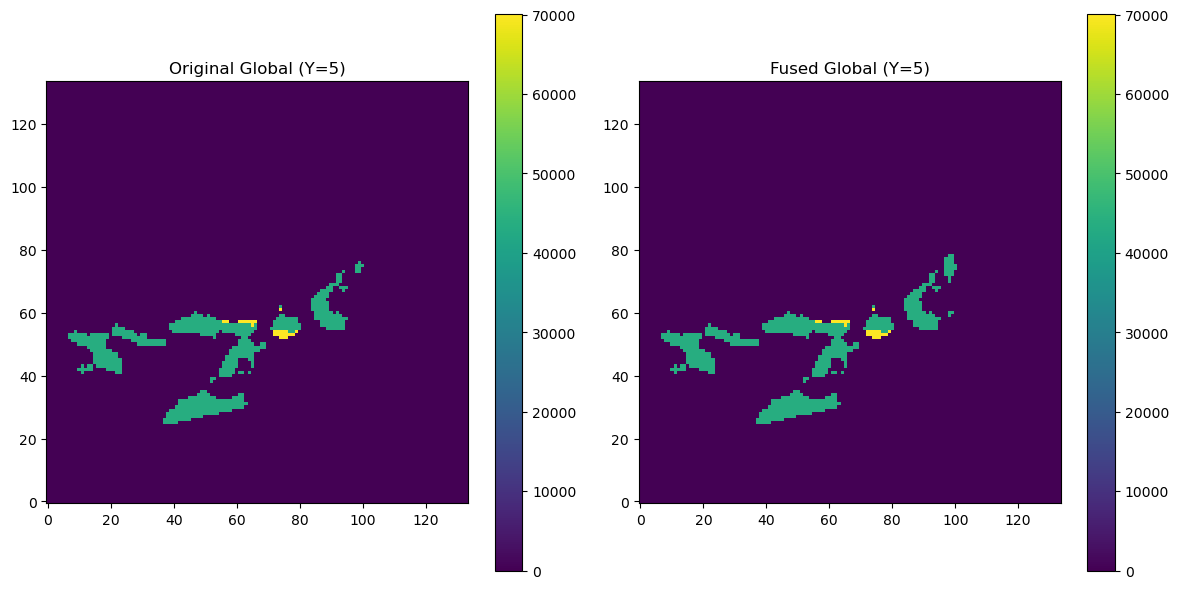

Max Diff: 43792.53561013937


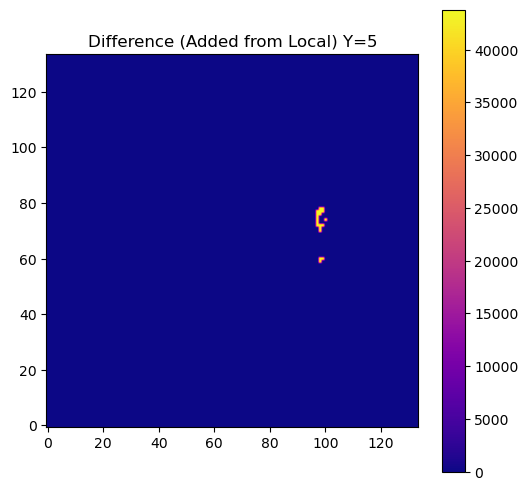

In [29]:
import matplotlib.pyplot as plt

# Visualization
def plot_compare_slice(original, fused, y_idx):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original
    im1 = axes[0].imshow(original[:, y_idx, :].T, origin='lower', cmap='viridis')
    axes[0].set_title(f"Original Global (Y={y_idx})")
    plt.colorbar(im1, ax=axes[0])
    
    # Fused
    im2 = axes[1].imshow(fused[:, y_idx, :].T, origin='lower', cmap='viridis')
    axes[1].set_title(f"Fused Global (Y={y_idx})")
    plt.colorbar(im2, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

# Find a layer with content
sample_y = 5 # Heuristic
plot_compare_slice(global_weight, fused_weight, sample_y)

# Also Difference Plot
diff = fused_weight - global_weight
print(f"Max Diff: {diff.max()}")
if diff.max() > 0:
    plt.figure(figsize=(6, 6))
    plt.imshow(diff[:, sample_y, :].T, origin='lower', cmap='plasma')
    plt.title(f"Difference (Added from Local) Y={sample_y}")
    plt.colorbar()
    plt.show()